**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell # make all output in ipython show, not just last line
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

This project requires Python 3.7 or above:

In [2]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [4]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [5]:
version.parse(tf.__version__)

<Version('2.10.1')>

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [7]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron
TLU - Threshold Logic Unit

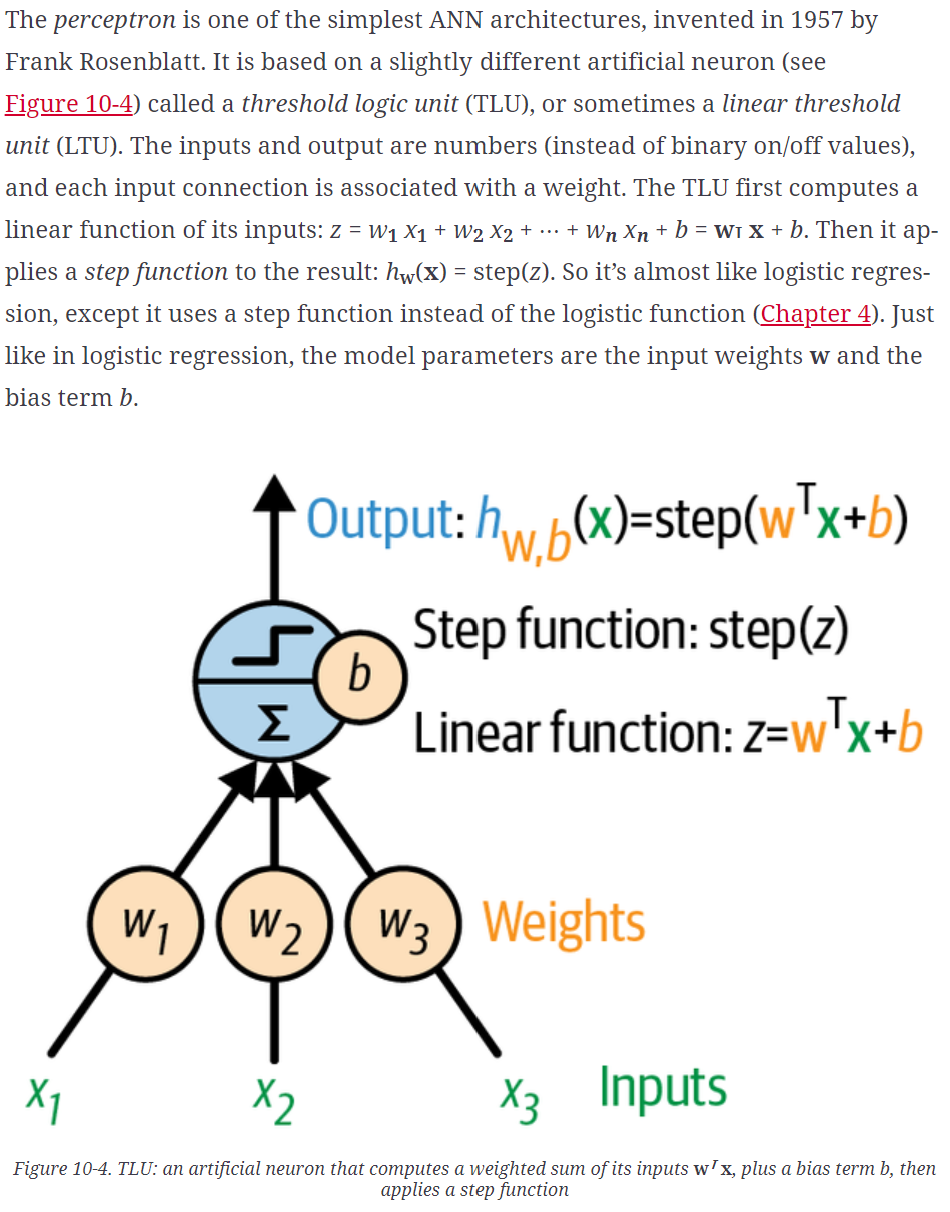
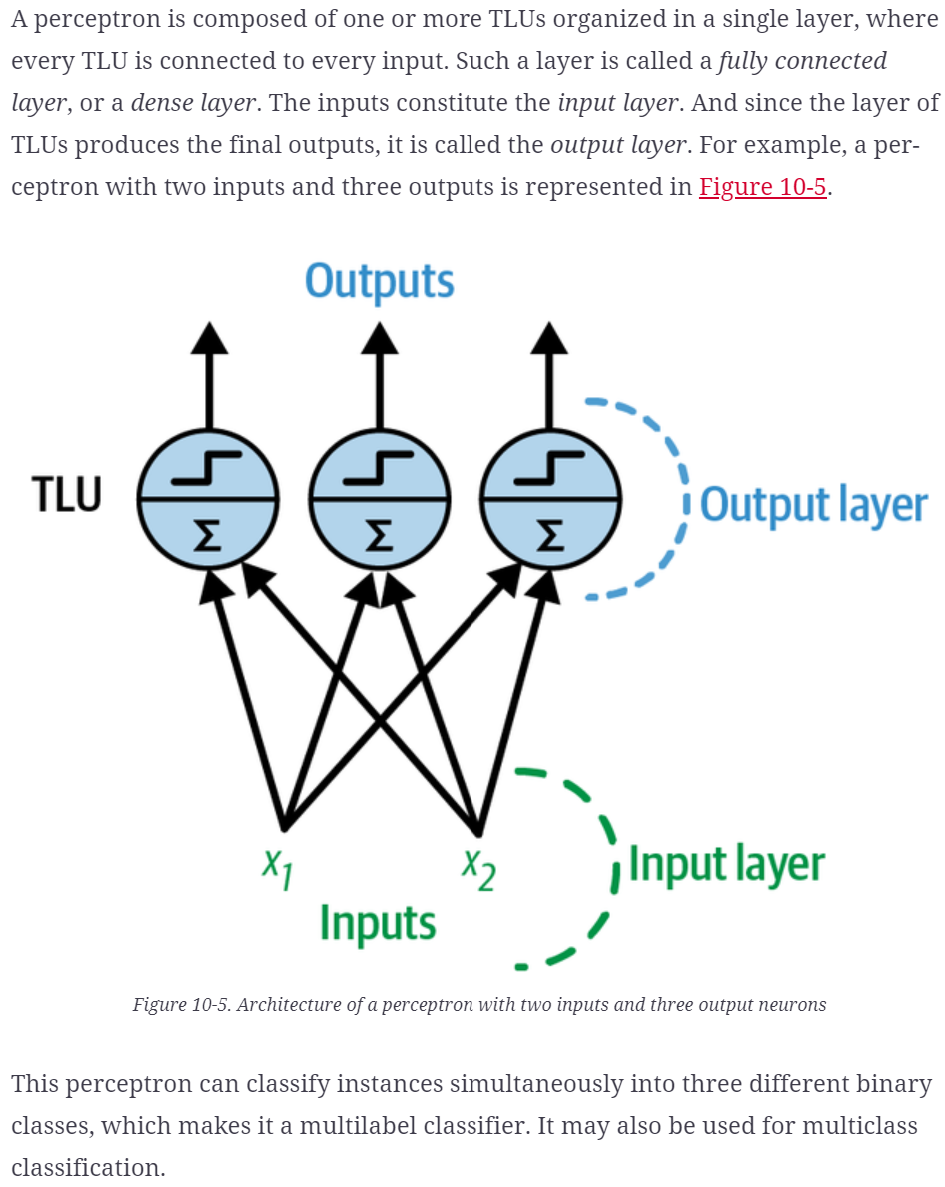
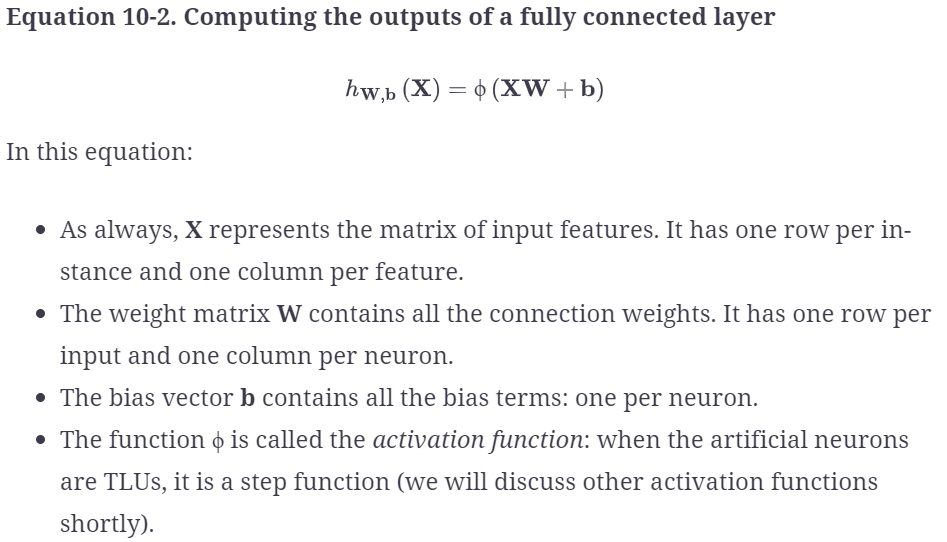
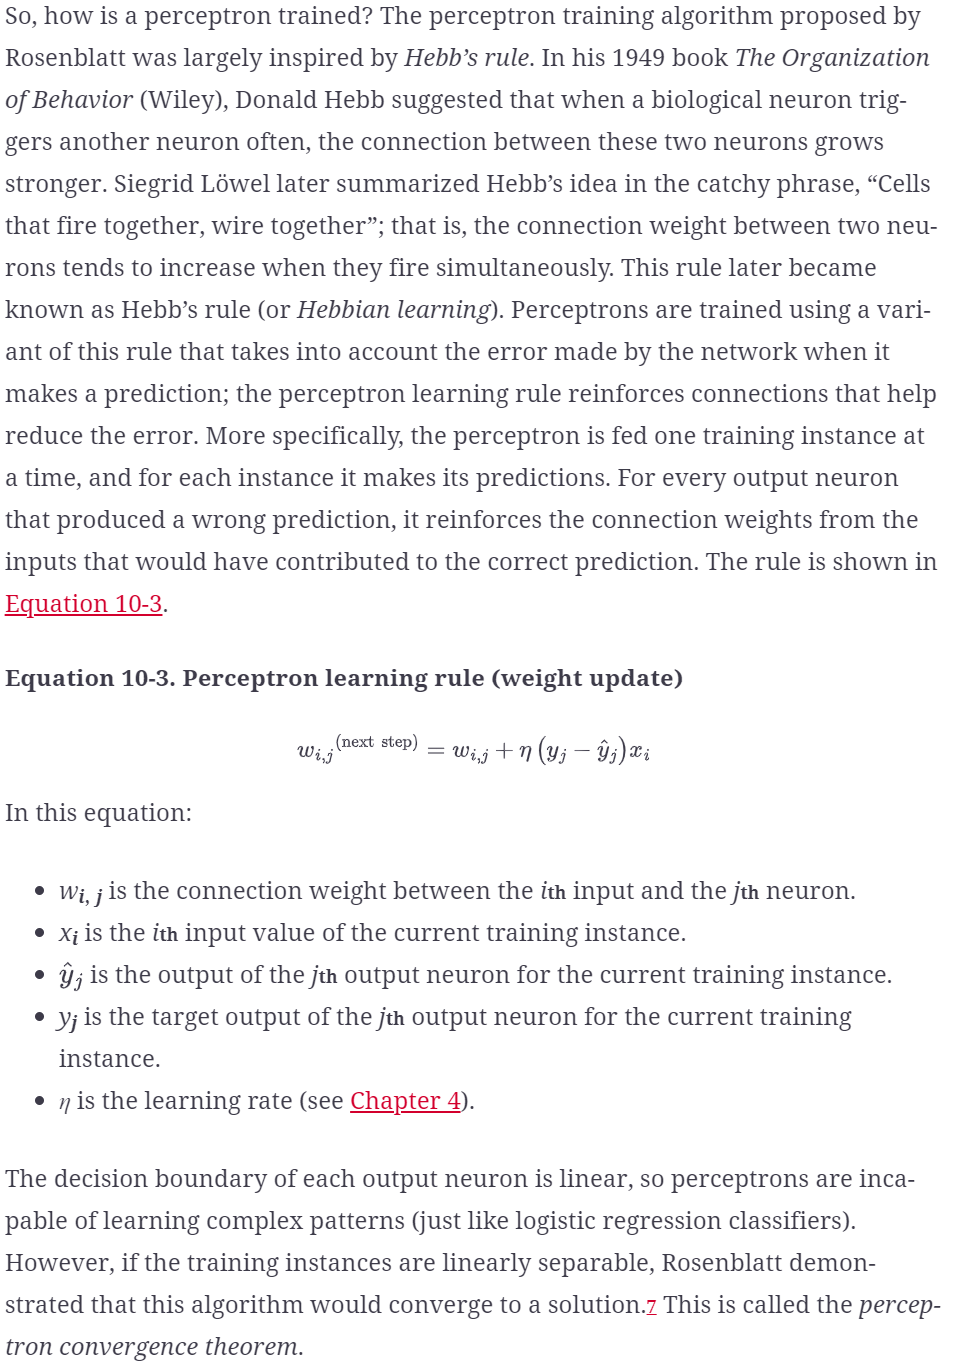

In [8]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

Perceptron(random_state=42)

You may have noticed that the perceptron learning algorithm strongly resembles stochastic gradient descent (introduced in Chapter 4). In fact, Scikit-Learn’s Perceptron class is equivalent to using an SGDClassifier with the following hyperparameters: loss="perceptron", learning_rate="constant", eta0=1 (the learning rate), and penalty=None (no regularization).

In [9]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [10]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

SGDClassifier(eta0=1, learning_rate='constant', loss='perceptron', penalty=None,
              random_state=42)

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

<Figure size 700x300 with 0 Axes>

Text(0.5, 0, 'Petal length')

Text(0, 0.5, 'Petal width')

(0.0, 5.0, 0.0, 2.0)

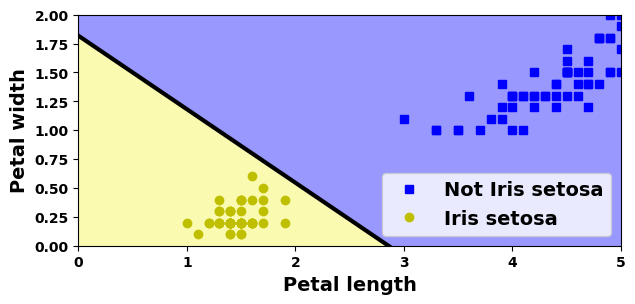

In [11]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

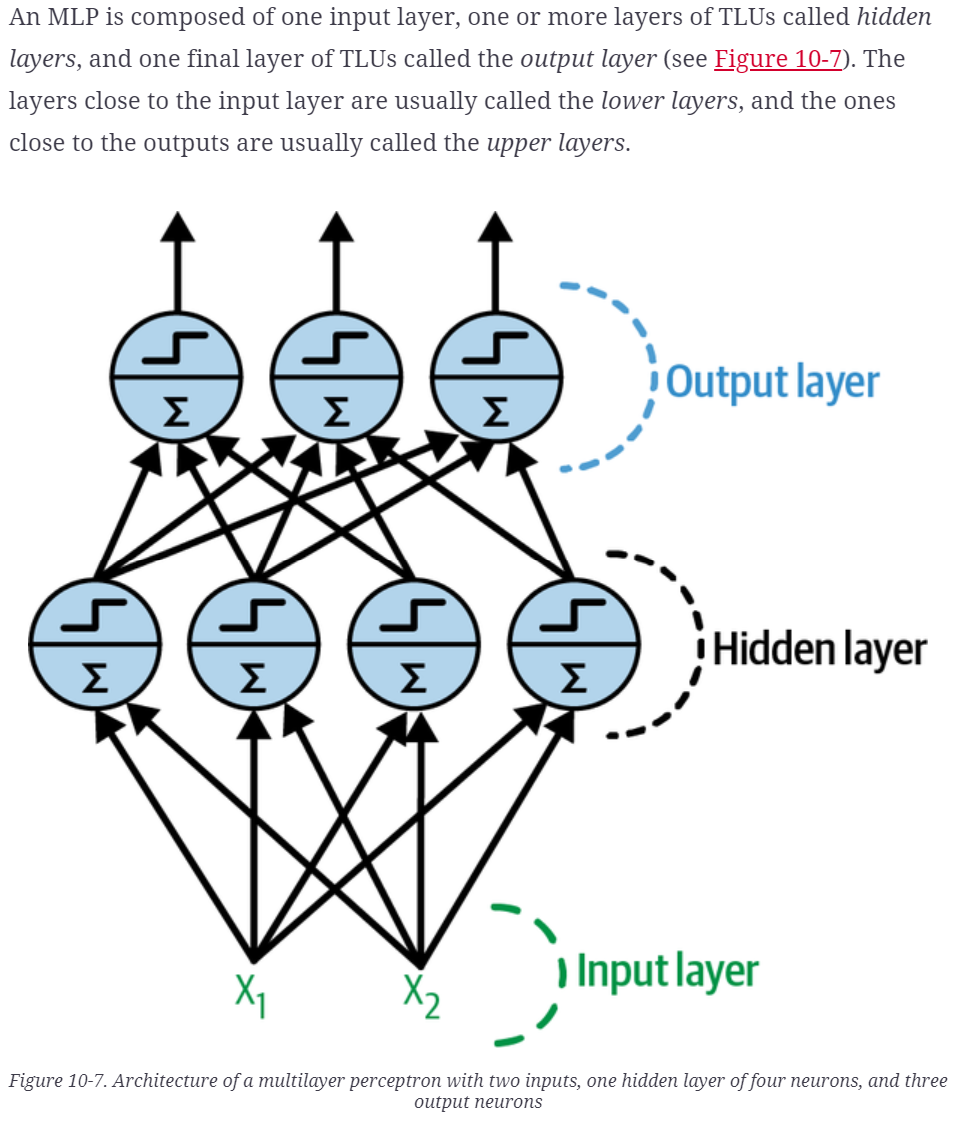
For many years researchers struggled to find a way to train MLPs, without success. In the early 1960s several researchers discussed the possibility of using gradient descent to train neural networks, but as we saw in Chapter 4, this requires computing the gradients of the model’s error with regard to the model parameters; it wasn’t clear at the time how to do this efficiently with such a complex model containing so many parameters, especially with the computers they had back then.

Then, in 1970, a researcher named Seppo Linnainmaa introduced in his master’s thesis a technique to compute all the gradients automatically and efficiently. This algorithm is now called reverse-mode automatic differentiation (or reverse-mode autodiff for short). In just two passes through the network (one forward, one backward), it is able to compute the gradients of the neural network’s error with regard to every single model parameter. In other words, it can find out how each connection weight and each bias should be tweaked in order to reduce the neural network’s error. These gradients can then be used to perform a gradient descent step. If you repeat this process of computing the gradients automatically and taking a gradient descent step, the neural network’s error will gradually drop until it eventually reaches a minimum. This combination of reverse-mode autodiff and gradient descent is now called backpropagation (or backprop for short).

Let’s run through how backpropagation works again in a bit more detail:

It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times. Each pass is called an epoch.

Each mini-batch enters the network through the input layer. The algorithm then computes the output of all the neurons in the first hidden layer, for every instance in the mini-batch. The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. This is the forward pass: it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.

Next, the algorithm measures the network’s output error (i.e., it uses a loss function that compares the desired output and the actual output of the network, and returns some measure of the error).

Then it computes how much each output bias and each connection to the output layer contributed to the error. This is done analytically by applying the chain rule (perhaps the most fundamental rule in calculus), which makes this step fast and precise.

The algorithm then measures how much of these error contributions came from each connection in the layer below, again using the chain rule, working backward until it reaches the input layer. As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights and biases in the network by propagating the error gradient backward through the network (hence the name of the algorithm).

Finally, the algorithm performs a gradient descent step to tweak all the connection weights in the network, using the error gradients it just computed.

It is important to initialize all the hidden layers’ connection weights randomly, or else training will fail. For example, if you initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical. In other words, despite having hundreds of neurons per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. If instead you randomly initialize the weights, you break the symmetry and allow backpropagation to train a diverse team of neurons.


**Activation functions**

In short, backpropagation makes predictions for a mini-batch (forward pass), measures the error, then goes through each layer in reverse to measure the error contribution from each parameter (reverse pass), and finally tweaks the connection weights and biases to reduce the error (gradient descent step).

In order for backprop to work properly, Rumelhart and his colleagues made a key change to the MLP’s architecture: they replaced the step function with the logistic function, σ(z) = 1 / (1 + exp(–z)), also called the sigmoid function. This was essential because the step function contains only flat segments, so there is no gradient to work with (gradient descent cannot move on a flat surface), while the sigmoid function has a well-defined nonzero derivative everywhere, allowing gradient descent to make some progress at every step. In fact, the backpropagation algorithm works well with many other activation functions, not just the sigmoid function. Here are two other popular choices:

The hyperbolic tangent function: tanh(z) = 2σ(2z) – 1
Just like the sigmoid function, this activation function is S-shaped, continuous, and differentiable, but its output value ranges from –1 to 1 (instead of 0 to 1 in the case of the sigmoid function). That range tends to make each layer’s output more or less centered around 0 at the beginning of training, which often helps speed up convergence.

The rectified linear unit function: ReLU(z) = max(0, z)
The ReLU function is continuous but unfortunately not differentiable at z = 0 (the slope changes abruptly, which can make gradient descent bounce around), and its derivative is 0 for z < 0. In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default.⁠11 Importantly, the fact that it does not have a maximum output value helps reduce some issues during gradient descent (we will come back to this in Chapter 11).

<Figure size 1100x310 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Activation functions')

(-4.5, 4.5, -1.65, 2.4)

<AxesSubplot:>

Text(0.5, 1.0, 'Derivatives')

(-4.5, 4.5, -0.2, 1.2)

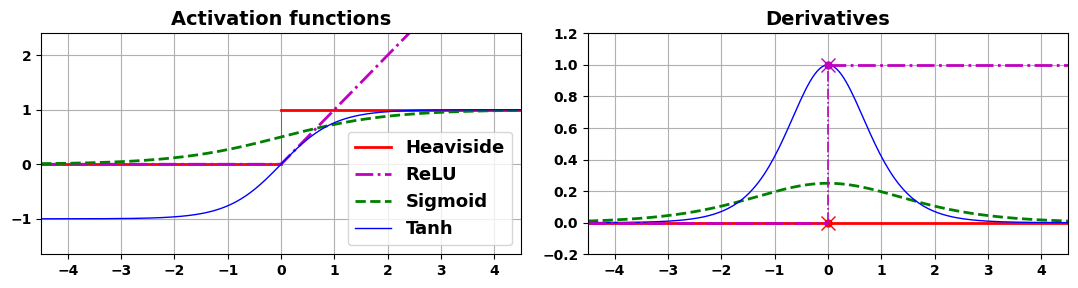

In [12]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

Why do we need activation functions in the first place? Well, if you chain several linear transformations, all you get is a linear transformation. For example, if f(x) = 2x + 3 and g(x) = 5x – 1, then chaining these two linear functions gives you another linear function: f(g(x)) = 2(5x – 1) + 3 = 10x + 1. So if you don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and you can’t solve very complex problems with that. Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.

## Regression MLPs

First, MLPs can be used for regression tasks. If you want to predict a single value (e.g., the price of a house, given many of its features), then you just need a single output neuron: its output is the predicted value. For multivariate regression (i.e., to predict multiple values at once), you need one output neuron per output dimension. For example, to locate the center of an object in an image, you need to predict 2D coordinates, so you need two output neurons. If you also want to place a bounding box around the object, then you need two more numbers: the width and the height of the object. So, you end up with four output neurons.

Scikit-Learn includes an MLPRegressor class, so let’s use it to build an MLP with three hidden layers composed of 50 neurons each, and train it on the California housing dataset. For simplicity, we will use Scikit-Learn’s fetch_california_housing() function to load the data. This dataset is simpler than the one we used in Chapter 2, since it contains only numerical features (there is no ocean_proximity feature), and there are no missing values. The following code starts by fetching and splitting the dataset, then it creates a pipeline to standardize the input features before sending them to the MLPRegressor. This is very important for neural networks because they are trained using gradient descent, and as we saw in Chapter 4, gradient descent does not converge very well when the features have very different scales. Finally, the code trains the model and evaluates its validation error. The model uses the ReLU activation function in the hidden layers, and it uses a variant of gradient descent called Adam (see Chapter 11) to minimize the mean squared error, with a little bit of ℓ2 regularization (which you can control via the alpha hyperparameter):

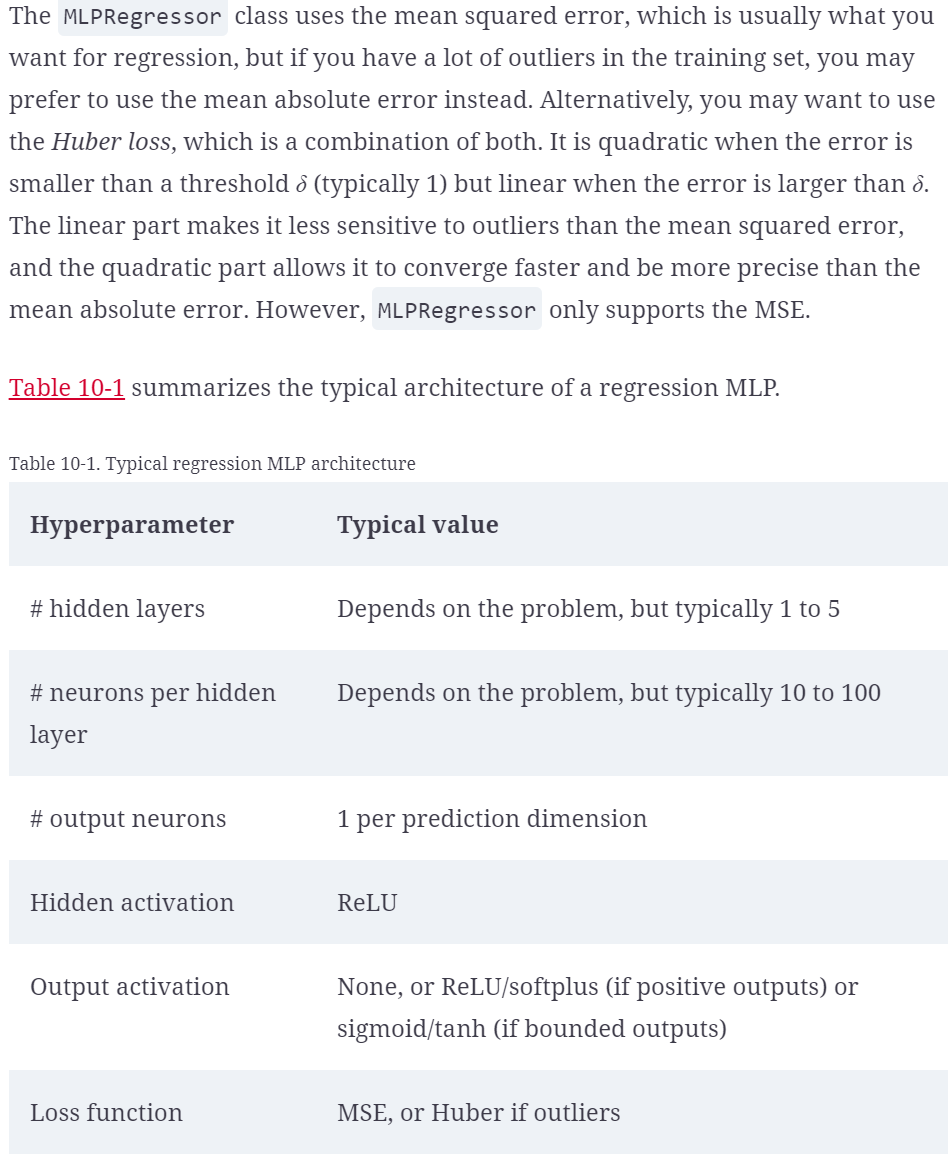

In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[50, 50, 50],
                              random_state=42))])

In [14]:
rmse

0.5053326657968797

## Classification MLPs
MLPs can also easily handle multilabel binary classification tasks (see Chapter 3). For example, you could have an email classification system that predicts whether each incoming email is ham or spam, and simultaneously predicts whether it is an urgent or nonurgent email. In this case, you would need two output neurons, both using the sigmoid activation function: the first would output the probability that the email is spam, and the second would output the probability that it is urgent. More generally, you would dedicate one output neuron for each positive class. Note that the output probabilities do not necessarily add up to 1. This lets the model output any combination of labels: you can have nonurgent ham, urgent ham, nonurgent spam, and perhaps even urgent spam (although that would probably be an error).

If each instance can belong only to a single class, out of three or more possible classes (e.g., classes 0 through 9 for digit image classification), then you need to have one output neuron per class, and you should use the softmax activation function for the whole output layer (see Figure 10-9). The softmax function (introduced in Chapter 4) will ensure that all the estimated probabilities are between 0 and 1 and that they add up to 1, since the classes are exclusive. As you saw in Chapter 3, this is called multiclass classification.

Regarding the loss function, since we are predicting probability distributions, the cross-entropy loss (or x-entropy or log loss for short, see Chapter 4) is generally a good choice.

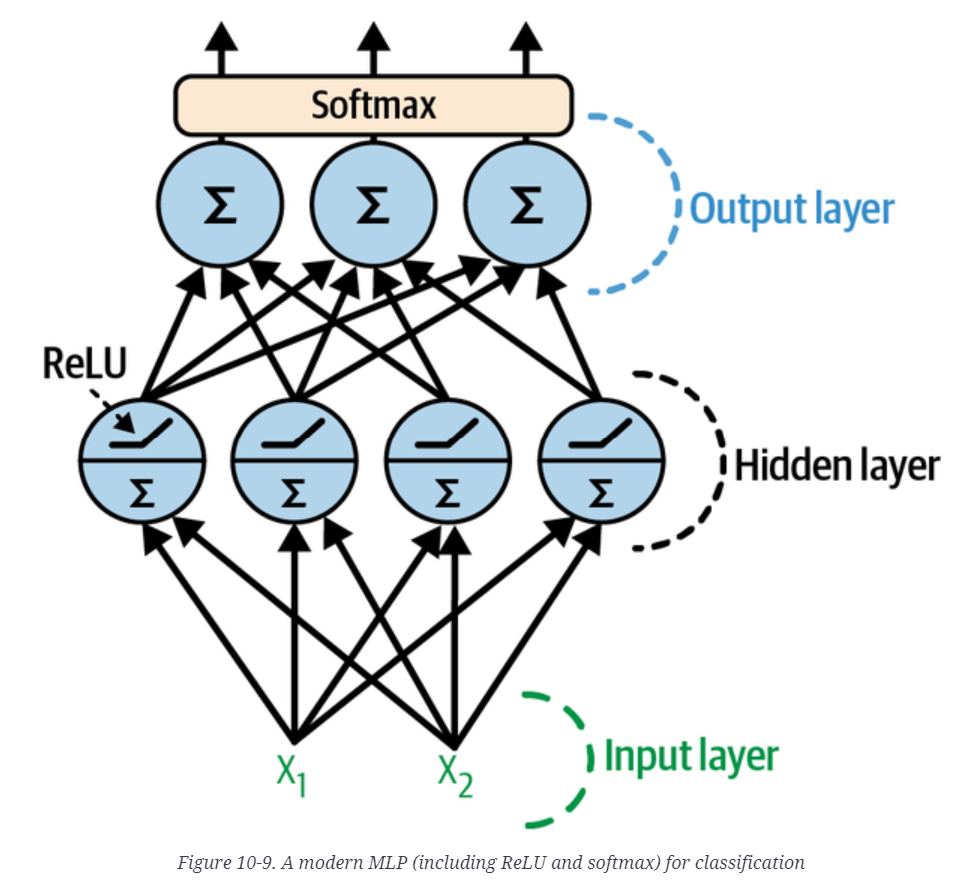

In [15]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=[5], max_iter=10000,
                               random_state=42))])

1.0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [16]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [17]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [18]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [19]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

(-0.5, 27.5, 27.5, -0.5)

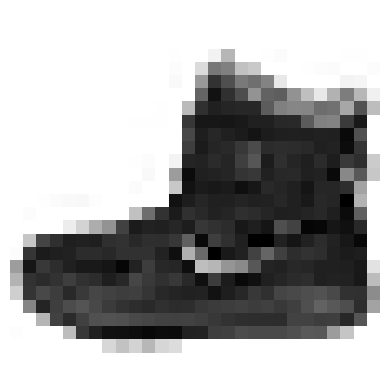

In [20]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [21]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [23]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

<Figure size 1200x480 with 0 Axes>

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Ankle boot')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Dress')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Pullover')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sneaker')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Pullover')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sandal')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sandal')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Ankle boot')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sandal')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sandal')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sneaker')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Ankle boot')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Trouser')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Shirt')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Coat')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Dress')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Trouser')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Coat')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Bag')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Coat')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Dress')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Pullover')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Coat')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Coat')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sandal')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Dress')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Shirt')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Shirt')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'T-shirt/top')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Bag')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Sandal')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Pullover')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Trouser')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Shirt')

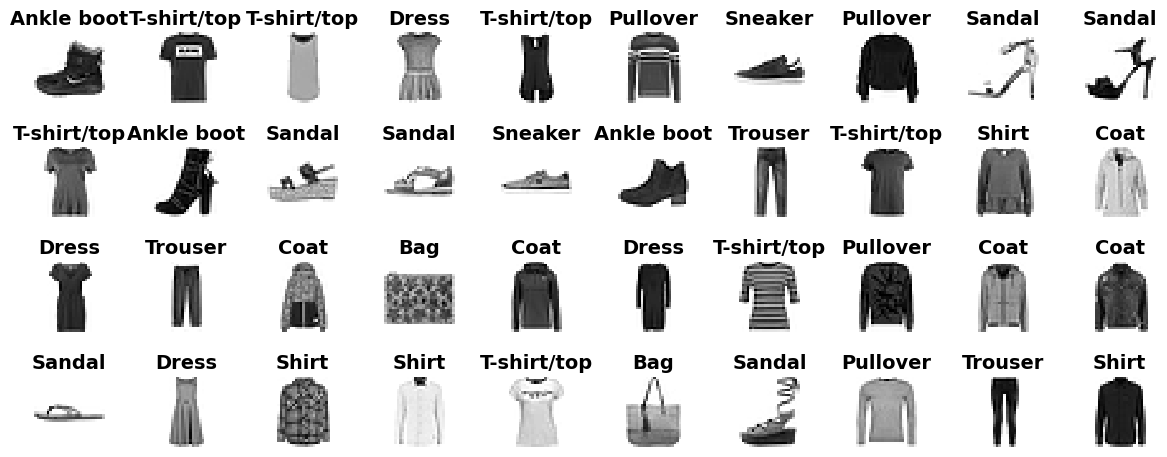

In [24]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Creating the model using the Sequential API

First, set TensorFlow’s random seed to make the results reproducible: the random weights of the hidden layers and the output layer will be the same every time you run the notebook. You could also choose to use the tf.keras.utils.set_random_seed() function, which conveniently sets the random seeds for TensorFlow, Python (random.seed()), and NumPy (np.random.seed()).

The next line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called the sequential API.

Next, we build the first layer (an Input layer) and add it to the model. We specify the input shape, which doesn’t include the batch size, only the shape of the instances. Keras needs to know the shape of the inputs so it can determine the shape of the connection weight matrix of the first hidden layer.

Then we add a Flatten layer. Its role is to convert each input image into a 1D array: for example, if it receives a batch of shape [32, 28, 28], it will reshape it to [32, 784]. In other words, if it receives input data X, it computes X.reshape(-1, 784). This layer doesn’t have any parameters; it’s just there to do some simple preprocessing.

Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). When it receives some input data, it computes Equation 10-2.

Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.

Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function because the classes are exclusive.

In [25]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

tf.keras.backend.clear_session()

TensorFlow is lazy-evaluated by default. TensorFlow operations aren't evaluated immediately: creating a tensor or doing some operations to it creates nodes in a dataflow graph. The results are calculated by evaluating the relevant parts of the graph in one go when you call tf.Session.run() or tf.Tensor.eval(). This is so TensorFlow can build an execution plan that allocates operations that can be performed in parallel to different devices. It can also fold adjacent nodes together or remove redundant ones (e.g. if you concatenated two tensors and later split them apart again unchanged). For more details, see https://www.tensorflow.org/guide/graphs.  The clear_seesion deletes teh execution graph to free up memory space.

In [26]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()  # clears memory space
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

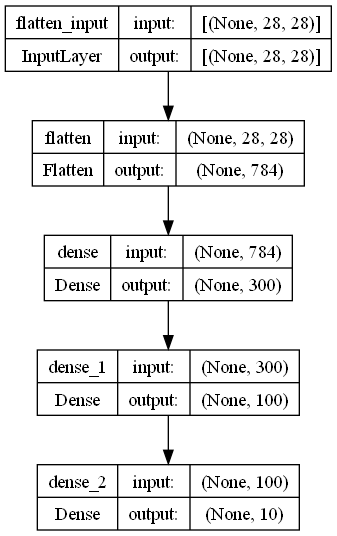

In [28]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [29]:
model.layers

In [30]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [31]:
model.get_layer('dense') is hidden1

True

In [32]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02159942,  0.02595699, -0.03853976, ..., -0.02006767,
        -0.03871411,  0.02489245],
       [ 0.00736224, -0.05957017,  0.04529095, ..., -0.0418376 ,
        -0.02289799,  0.03342695],
       [ 0.06286553, -0.05087653, -0.04953237, ..., -0.01595502,
         0.00875966,  0.07220845],
       ...,
       [-0.0584769 , -0.01142834, -0.06782934, ..., -0.01056516,
        -0.00027316, -0.04921249],
       [-0.01698891,  0.06305997, -0.01211121, ..., -0.03872966,
        -0.0538164 ,  0.03411055],
       [ 0.05330296, -0.01379872,  0.03809974, ..., -0.05492486,
        -0.02892966,  0.06952454]], dtype=float32)

In [33]:
weights.shape

(784, 300)

In [34]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
biases.shape

(300,)

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry, as discussed earlier), and the biases were initialized to zeros, which is fine. If you want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer.

### Compiling the model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation:



In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

In [37]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])  # optimizer is stochastic gradient descent

Using loss="sparse_categorical_crossentropy" is the equivalent of using loss=tf.keras.losses.sparse_categorical_​cross⁠entropy. Similarly, using optimizer="sgd" is the equivalent of using optimizer=tf.keras.optimizers.SGD(), and using metrics=["accuracy"] is the equivalent of using metrics=​[tf.keras.metrics.sparse_categorical_accuracy] (when using this loss). We will use many other losses, optimizers, and metrics in this book; for the full lists, see https://keras.io/api/losses, https://keras.io/api/optimizers, and https://keras.io/api/metrics.

This code requires explanation. We use the "sparse_categorical_crossentropy" loss because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g., [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. If we were doing binary classification or multilabel binary classification, then we would use the "sigmoid" activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

In [38]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [39]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

### Training and evaluating the model

We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution). We also pass a validation set (this is optional). Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set, or there is a bug, such as a data mismatch between the training set and the validation set.

Shape errors are quite common, especially when getting started, so you should familiarize yourself with the error messages: try fitting a model with inputs and/or labels of the wrong shape, and see the errors you get. Similarly, try compiling the model with loss="categorical_crossentropy" instead of loss="sparse_​cat⁠egorical_crossentropy". Or you can remove the Flatten layer.

In [40]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7086 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.5090 - val_sparse_categorical_accuracy: 0.8352
Epoch 2/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4857 - sparse_categorical_accuracy: 0.8319 - val_loss: 0.4647 - val_sparse_categorical_accuracy: 0.8372
Epoch 3/30
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4400 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.4212 - val_sparse_categorical_accuracy: 0.8556
Epoch 4/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4153 - sparse_categorical_accuracy: 0.8550 - val_loss: 0.4001 - val_sparse_categorical_accuracy: 0.8608
Epoch 5/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3952 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.3925 - val_sparse_categorical_accuracy: 0.8586
Epoch 6/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3789 - 

At each epoch during training, Keras displays the number of mini-batches processed so far on the left side of the progress bar. The batch size is 32 by default, and since the training set has 55,000 images, the model goes through 1,719 batches per epoch: 1,718 of size 32, and 1 of size 24. After the progress bar, you can see the mean training time per sample, and the loss and accuracy (or any other extra metrics you asked for) on both the training set and the validation set. Notice that the training loss went down, which is a good sign, and the validation accuracy reached 88.94% after 30 epochs. That’s slightly below the training accuracy, so there is a little bit of overfitting going on, but not a huge amount.

Instead of passing a validation set using the validation_data argument, you could set validation_split to the ratio of the training set that you want Keras to use for validation. For example, validation_split=0.1 tells Keras to use the last 10% of the data (before shuffling) for validation.

If the training set was very skewed, with some classes being overrepresented and others underrepresented, it would be useful to set the class_weight argument when calling the fit() method, to give a larger weight to underrepresented classes and a lower weight to overrepresented classes. These weights would be used by Keras when computing the loss. If you need per-instance weights, set the sample_weight argument. If both class_weight and sample_weight are provided, then Keras multiplies them. Per-instance weights could be useful, for example, if some instances were labeled by experts while others were labeled using a crowdsourcing platform: you might want to give more weight to the former. You can also provide sample weights (but not class weights) for the validation set by adding them as a third item in the validation_data tuple.

The fit() method returns a History object containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any). If you use this dictionary to create a Pandas DataFrame and call its plot() method, you get the learning curves shown in Figure 10-11:

In [41]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [42]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


<AxesSubplot:xlabel='Epoch'>

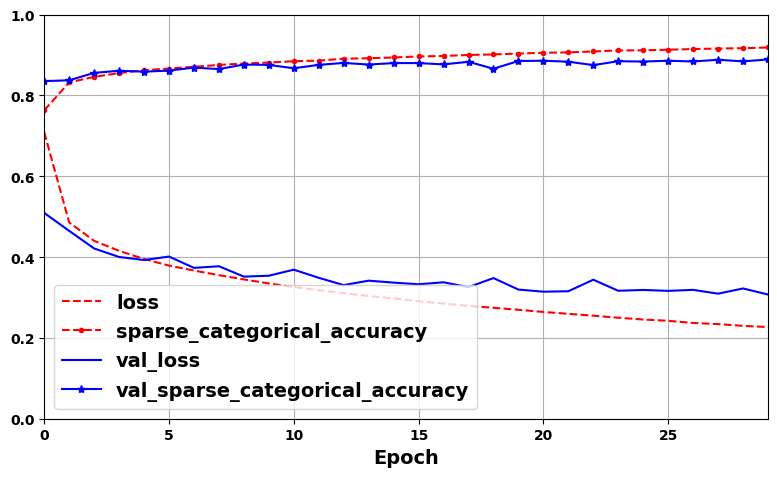

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Epoch')

(-0.5, 29.0, 0.0, 1.0)

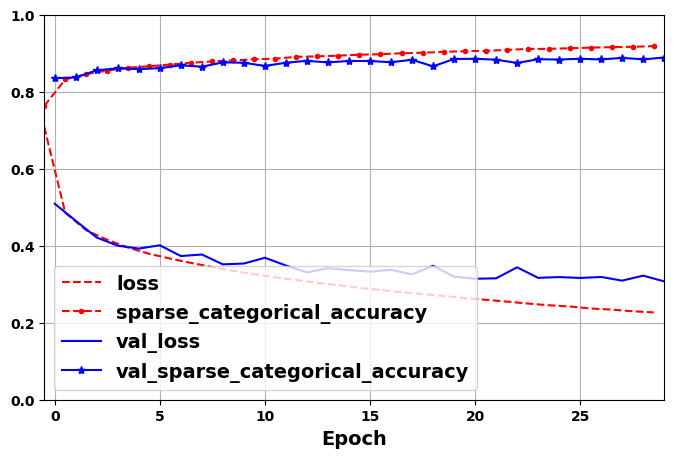

In [44]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

You can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. This is good. The validation curves are relatively close to each other at first, but they get further apart over time, which shows that there’s a little bit of overfitting. In this particular case, the model looks like it performed better on the validation set than on the training set at the beginning of training, but that’s not actually the case. The validation error is computed at the end of each epoch, while the training error is computed using a running mean during each epoch, so the training curve should be shifted by half an epoch to the left. If you do that, you will see that the training and validation curves overlap almost perfectly at the beginning of training.

The training set performance ends up beating the validation performance, as is generally the case when you train for long enough. You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue training. This is as simple as calling the fit() method again, since Keras just continues training where it left off: you should be able to reach about 89.8% validation accuracy, while the training accuracy will continue to rise up to 100% (this is not always the case).

In [45]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.3240 - sparse_categorical_accuracy: 0.8839


[0.3239707946777344, 0.883899986743927]

If you are not satisfied with the performance of your model, you should go back and tune the hyperparameters. The first one to check is the learning rate. If that doesn’t help, try another optimizer (and always retune the learning rate after changing any hyperparameter). If the performance is still not great, then try tuning model hyperparameters such as the number of layers, the number of neurons per layer, and the types of activation functions to use for each hidden layer. You can also try tuning other hyperparameters, such as the batch size (it can be set in the fit() method using the batch_size argument, which defaults to 32). We will get back to hyperparameter tuning at the end of this chapter. Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the evaluate() method (it also supports several other arguments, such as batch_size and sample_weight

### Using the model to make predictions

In [46]:
X_new = X_test[:3]  # first three instances of the test set
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 114ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

For the first image it estimates that the probability of class 9 (ankle boot) is 96%, the probability of class 7 (sneaker) is 2%, the probability of class 5 (sandal) is 1%, and the probabilities of the other classes are negligible. In other words, it is highly confident that the first image is footwear, most likely ankle boots but possibly sneakers or sandals. If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the argmax() method to get the highest probability class index for each instance.

In [47]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [48]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [49]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

<Figure size 720x240 with 0 Axes>

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Ankle boot')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Pullover')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, 'Trouser')

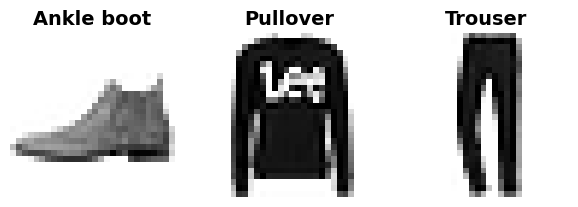

In [50]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

Using the sequential API to build, train, evaluate, and use a regression MLP is quite similar to what we did for classification. The main differences in the following code example are the fact that the output layer has a single neuron (since we only want to predict a single value) and it uses no activation function, the loss function is the mean squared error, the metric is the RMSE, and we’re using an Adam optimizer like Scikit-Learn’s MLPRegressor did. Moreover, in this example we don’t need a Flatten layer, and instead we’re using a Normalization layer as the first layer: it does the same thing as Scikit-Learn’s StandardScaler, but it must be fitted to the training data using its adapt() method before you call the model’s fit() method. (Keras has other preprocessing layers, which will be covered in Chapter 13).

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [51]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [52]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 3s 7ms/step - loss: 0.8652 - root_mean_squared_error: 0.9301 - val_loss: 0.3815 - val_root_mean_squared_error: 0.6177
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.3808 - root_mean_squared_error: 0.6171 - val_loss: 1.8029 - val_root_mean_squared_error: 1.3427
Epoch 3/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3607 - root_mean_squared_error: 0.6006 - val_loss: 0.3790 - val_root_mean_squared_error: 0.6156
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3367 - root_mean_squared_error: 0.5803 - val_loss: 0.5886 - val_root_mean_squared_error: 0.7672
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3232 - root_mean_squared_error: 0.5685 - val_loss: 0.4984 - val_root_mean_squared_error: 0.7060
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3124 - root_mean_squared_error: 0.5590 - val_loss: 0.3430 - val_

In [53]:
rmse_test

0.5350685119628906

In [54]:
y_pred

array([[0.5327287],
       [1.0639595],
       [5.2286496]], dtype=float32)

## Building Complex Models Using the Functional API

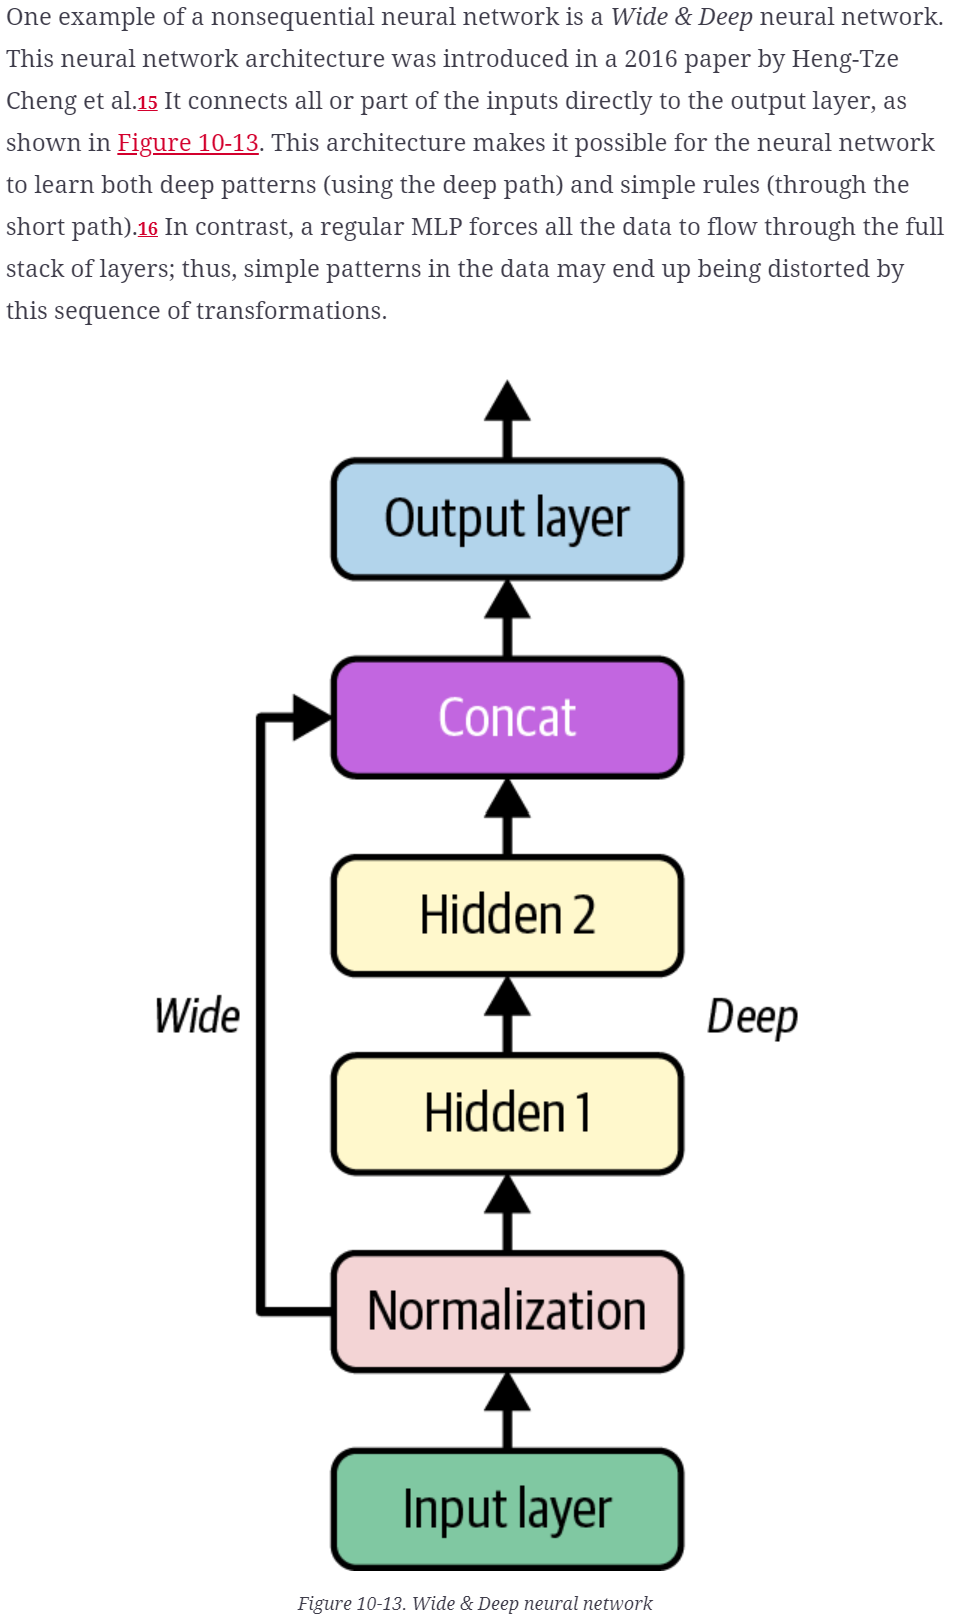

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [55]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [56]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

First, we create five layers: a Normalization layer to standardize the inputs, two Dense layers with 30 neurons each, using the ReLU activation function, a Concatenate layer, and one more Dense layer with a single neuron for the output layer, without any activation function.

Next, we create an Input object (the variable name input_ is used to avoid overshadowing Python’s built-in input() function). This is a specification of the kind of input the model will get, including its shape and optionally its dtype, which defaults to 32-bit floats. A model may actually have multiple inputs, as you will see shortly.

Then we use the Normalization layer just like a function, passing it the Input object. This is why this is called the functional API. Note that we are just telling Keras how it should connect the layers together; no actual data is being processed yet, as the Input object is just a data specification. In other words, it’s a symbolic input. The output of this call is also symbolic: normalized doesn’t store any actual data, it’s just used to construct the model.

In the same way, we then pass normalized to hidden_layer1, which outputs hidden1, and we pass hidden1 to hidden_layer2, which outputs hidden2.

So far we’ve connected the layers sequentially, but then we use the concat_layer to concatenate the input and the second hidden layer’s output. Again, no actual data is concatenated yet: it’s all symbolic, to build the model.

Then we pass concat to the output_layer, which gives us the final output.

Lastly, we create a Keras Model, specifying which inputs and outputs to use.

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 1.6851 - root_mean_squared_error: 1.2981 - val_loss: 1.0730 - val_root_mean_squared_error: 1.0359
Epoch 2/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4538 - root_mean_squared_error: 0.6737 - val_loss: 1.2461 - val_root_mean_squared_error: 1.1163
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4076 - root_mean_squared_error: 0.6384 - val_loss: 0.4980 - val_root_mean_squared_error: 0.7057
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3780 - root_mean_squared_error: 0.6148 - val_loss: 0.5741 - val_root_mean_squared_error: 0.7577
Epoch 5/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3682 - root_mean_squared_error: 0.6068 - val_loss: 2.2238 - val_root_mean_squared_error: 1.4912
Epoch 6/20
363/363 [==============================] - 2s 5ms/step - loss: 0.3708 - root_mean_squared_error: 0.6090 - val_loss: 3.5647 - val_

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

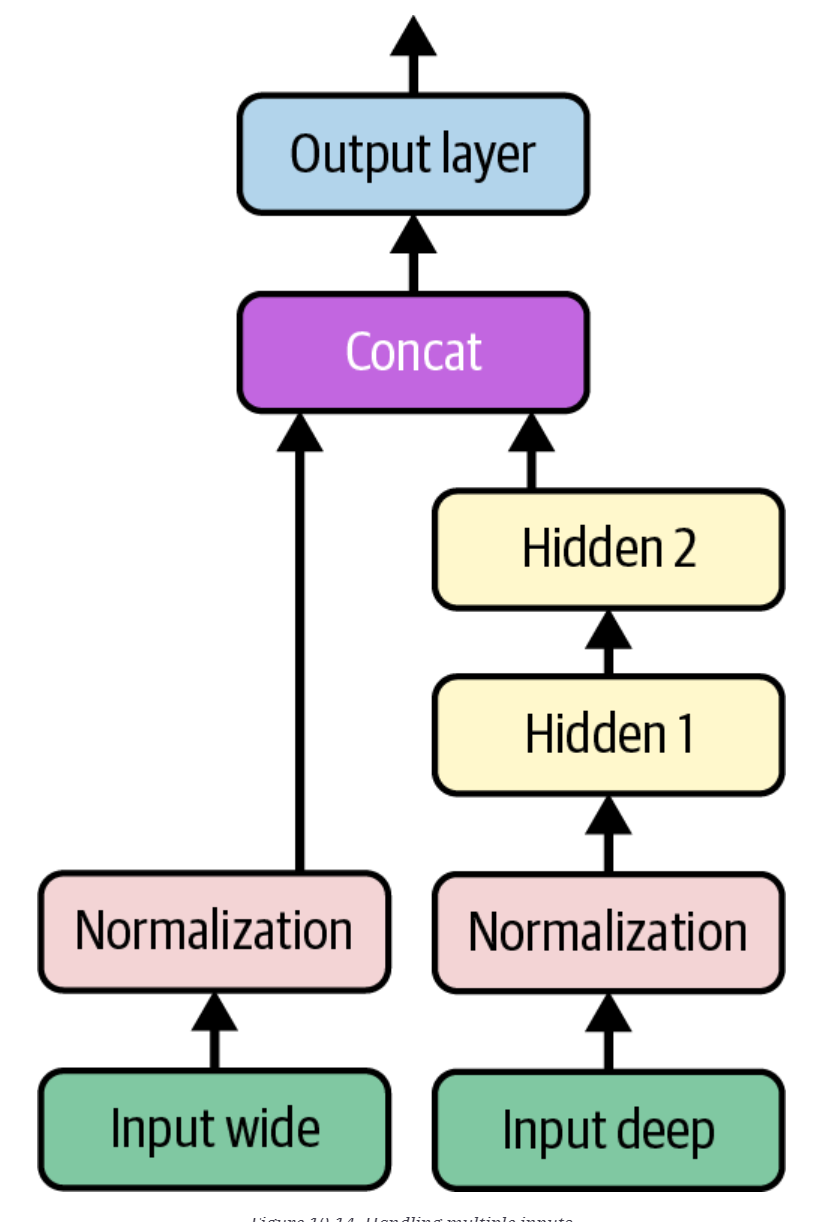

Each Dense layer is created and called on the same line. This is a common practice, as it makes the code more concise without losing clarity. However, we can’t do this with the Normalization layer since we need a reference to the layer to be able to call its adapt() method before fitting the model.

We used tf.keras.layers.concatenate(), which creates a Concatenate layer and calls it with the given inputs.

We specified inputs=[input_wide, input_deep] when creating the model, since there are two inputs.

In [59]:
tf.random.set_seed(42)  # extra code

In [60]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

Now we can compile the model as usual, but when we call the fit() method, instead of passing a single input matrix X_train, we must pass a pair of matrices (X_train_wide, X_train_deep), one per input. The same is true for X_valid, and also for X_test and X_new when you call evaluate() or predict():

In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 3s 7ms/step - loss: 1.5779 - root_mean_squared_error: 1.2562 - val_loss: 0.7790 - val_root_mean_squared_error: 0.8826
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5683 - root_mean_squared_error: 0.7539 - val_loss: 1.8340 - val_root_mean_squared_error: 1.3542
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4672 - root_mean_squared_error: 0.6835 - val_loss: 0.4902 - val_root_mean_squared_error: 0.7001
Epoch 4/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4058 - root_mean_squared_error: 0.6370 - val_loss: 0.5105 - val_root_mean_squared_error: 0.7145
Epoch 5/20
363/363 [==============================] - 2s 7ms/step - loss: 0.3804 - root_mean_squared_error: 0.6168 - val_loss: 1.5676 - val_root_mean_squared_error: 1.2520
Epoch 6/20
363/363 [==============================] - 2s 7ms/step - loss: 0.3778 - root_mean_squared_error: 0.6147 - val_loss: 2.3802 - val_

There are also many use cases in which you may want to have multiple outputs:

The task may demand it. For instance, you may want to locate and classify the main object in a picture. This is both a regression tasks and a classification task.

Similarly, you may have multiple independent tasks based on the same data. Sure, you could train one neural network per task, but in many cases you will get better results on all tasks by training a single neural network with one output per task. This is because the neural network can learn features in the data that are useful across tasks. For example, you could perform multitask classification on pictures of faces, using one output to classify the person’s facial expression (smiling, surprised, etc.) and another output to identify whether they are wearing glasses or not.

Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add an auxiliary output in a neural network architecture (see Figure 10-15) to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

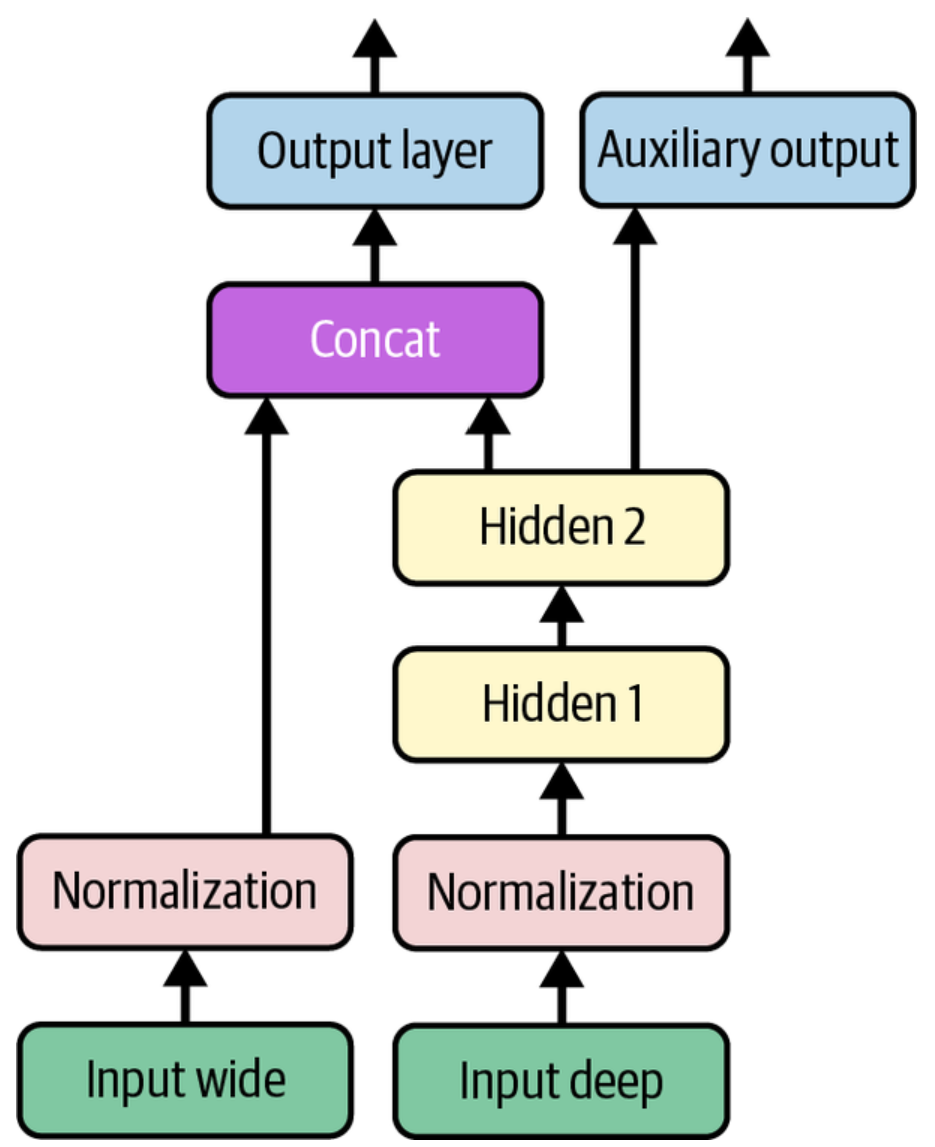

Adding an auxiliary output for regularization:

In [62]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [63]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
# above is the same, below creates the second output: aux_output
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

Each output will need its own loss function. Therefore, when we compile the model, we should pass a list of losses. If we pass a single loss, Keras will assume that the same loss must be used for all outputs. By default, Keras will compute all the losses and simply add them up to get the final loss used for training. Since we care much more about the main output than about the auxiliary output (as it is just used for regularization), we want to give the main output’s loss a much greater weight. Luckily, it is possible to set all the loss weights when compiling the model:

In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
# you can pass a dictionary loss={"output": "mse", "aux_output": "mse"}, assuming you created the output layers with name="output" and name="aux_output"

Now when we train the model, we need to provide labels for each output. In this example, the main output and the auxiliary output should try to predict the same thing, so they should use the same labels. So instead of passing y_train, we need to pass (y_train, y_train), or a dictionary {"output": y_train, "aux_output": y_train} if the outputs were named "output" and "aux_output". The same goes for y_valid and y_test:

In [65]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 4s 9ms/step - loss: 1.6098 - dense_2_loss: 1.5669 - dense_3_loss: 1.9955 - dense_2_root_mean_squared_error: 1.2518 - dense_3_root_mean_squared_error: 1.4126 - val_loss: 0.9263 - val_dense_2_loss: 0.8317 - val_dense_3_loss: 1.7778 - val_dense_2_root_mean_squared_error: 0.9120 - val_dense_3_root_mean_squared_error: 1.3333
Epoch 2/20
363/363 [==============================] - 3s 9ms/step - loss: 0.5576 - dense_2_loss: 0.5469 - dense_3_loss: 0.6545 - dense_2_root_mean_squared_error: 0.7395 - dense_3_root_mean_squared_error: 0.8090 - val_loss: 2.7847 - val_dense_2_loss: 2.9417 - val_dense_3_loss: 1.3716 - val_dense_2_root_mean_squared_error: 1.7151 - val_dense_3_root_mean_squared_error: 1.1712
Epoch 3/20
363/363 [==============================] - 3s 8ms/step - loss: 0.4872 - dense_2_loss: 0.4775 - dense_3_loss: 0.5743 - dense_2_root_mean_squared_error: 0.6910 - dense_3_root_mean_squared_error: 0.7578 - val_loss: 0.5608 - val_dense_2_loss

In [66]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

162/162 [==============================] - 1s 5ms/step - loss: 0.3422 - dense_2_loss: 0.3359 - dense_3_loss: 0.3988 - dense_2_root_mean_squared_error: 0.5795 - dense_3_root_mean_squared_error: 0.6315


In [67]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 76ms/step


In [68]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 [==============================] - 0s 24ms/step


## Using the Subclassing API to Build Dynamic Models

Both the sequential API and the functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. This has many advantages: the model can easily be saved, cloned, and shared; its structure can be displayed and analyzed; the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It’s also fairly straightforward to debug, since the whole model is a static graph of layers. But the flip side is just that: it’s static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the subclassing API is for you.

With this approach, you subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the functional API:

In [69]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

This example looks like the previous one, except we separate the creation of the layers⁠ in the constructor from their usage in the call() method. And we don’t need to create the Input objects: we can use the input argument to the call() method.

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 4s 8ms/step - loss: 1.7842 - output_1_loss: 1.7207 - output_2_loss: 2.3562 - output_1_root_mean_squared_error: 1.3118 - output_2_root_mean_squared_error: 1.5350 - val_loss: 1.0448 - val_output_1_loss: 0.6733 - val_output_2_loss: 4.3887 - val_output_1_root_mean_squared_error: 0.8205 - val_output_2_root_mean_squared_error: 2.0949
Epoch 2/10
363/363 [==============================] - 3s 8ms/step - loss: 0.5685 - output_1_loss: 0.5426 - output_2_loss: 0.8016 - output_1_root_mean_squared_error: 0.7366 - output_2_root_mean_squared_error: 0.8953 - val_loss: 0.7464 - val_output_1_loss: 0.7557 - val_output_2_loss: 0.6625 - val_output_1_root_mean_squared_error: 0.8693 - val_output_2_root_mean_squared_error: 0.8139
Epoch 3/10
363/363 [==============================] - 3s 9ms/step - loss: 0.4558 - output_1_loss: 0.4397 - output_2_loss: 0.6000 - output_1_root_mean_squared_error: 0.6631 - output_2_root_mean_squared_error: 0.7746 - val_loss: 0.406

The big difference with this API is that you can include pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations—your imagination is the limit

## Saving and Restoring a Model

the saved_model.pb file contains the model’s architecture and logic in the form of a serialized computation graph, so you don’t need to deploy the model’s source code in order to use it in production; the SavedModel is sufficient (you will see how this works in Chapter 12). The keras_metadata.pb file contains extra information needed by Keras. The variables subdirectory contains all the parameter values (including the connection weights, the biases, the normalization statistics, and the optimizer’s parameters), possibly split across multiple files if the model is very large. Lastly, the assets directory may contain extra files, such as data samples, feature names, class names, and so on. By default, the assets directory is empty. Since the optimizer is also saved, including its hyperparameters and any state it may have, after loading the model you can continue training if you want.

In [71]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

In [72]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


In [73]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


In [74]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 128ms/step


In [75]:
model.save_weights("my_weights")  # save only the weights

In [76]:
model.load_weights("my_weights")

In [77]:
# extra code – show the list of my_weights.* files
for path in sorted(Path().glob("my_weights.*")):
    print(path)

my_weights.data-00000-of-00001
my_weights.index


## Using Callbacks

The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call before and after training, before and after each epoch, and even before and after processing each batch. For example, the ModelCheckpoint callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch:

Moreover, if you use a validation set during training, you can set save_​best_only=True when creating the ModelCheckpoint. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last saved model after training, and this will be the best model on the validation set. This is one way to implement early stopping (introduced in Chapter 4), but it won’t actually stop training.

Another way is to use the EarlyStopping callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and if you set restore_best_weights=True it will roll back to the best model at the end of training. You can combine both callbacks to save checkpoints of your model in case your computer crashes, and interrupt training early when there is no more progress, to avoid wasting time and resources and to reduce overfitting:

In [78]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

In [79]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 5s 12ms/step - loss: 0.3627 - output_1_loss: 0.3554 - output_2_loss: 0.4281 - output_1_root_mean_squared_error: 0.5962 - output_2_root_mean_squared_error: 0.6543 - val_loss: 0.3298 - val_output_1_loss: 0.3147 - val_output_2_loss: 0.4655 - val_output_1_root_mean_squared_error: 0.5610 - val_output_2_root_mean_squared_error: 0.6823
Epoch 2/10
363/363 [==============================] - 4s 11ms/step - loss: 0.3447 - output_1_loss: 0.3373 - output_2_loss: 0.4117 - output_1_root_mean_squared_error: 0.5808 - output_2_root_mean_squared_error: 0.6416 - val_loss: 0.6922 - val_output_1_loss: 0.6769 - val_output_2_loss: 0.8298 - val_output_1_root_mean_squared_error: 0.8227 - val_output_2_root_mean_squared_error: 0.9109
Epoch 3/10
363/363 [==============================] - 4s 10ms/step - loss: 0.3450 - output_1_loss: 0.3381 - output_2_loss: 0.4076 - output_1_root_mean_squared_error: 0.5814 - output_2_root_mean_squared_error: 0.6384 - val_loss: 0.

In [80]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 4s 11ms/step - loss: 0.3310 - output_1_loss: 0.3242 - output_2_loss: 0.3921 - output_1_root_mean_squared_error: 0.5694 - output_2_root_mean_squared_error: 0.6262 - val_loss: 0.9033 - val_output_1_loss: 0.9342 - val_output_2_loss: 0.6246 - val_output_1_root_mean_squared_error: 0.9665 - val_output_2_root_mean_squared_error: 0.7903
Epoch 2/100
363/363 [==============================] - 4s 10ms/step - loss: 0.3303 - output_1_loss: 0.3245 - output_2_loss: 0.3829 - output_1_root_mean_squared_error: 0.5696 - output_2_root_mean_squared_error: 0.6188 - val_loss: 1.3470 - val_output_1_loss: 1.3839 - val_output_2_loss: 1.0155 - val_output_1_root_mean_squared_error: 1.1764 - val_output_2_root_mean_squared_error: 1.0077
Epoch 3/100
363/363 [==============================] - 4s 11ms/step - loss: 0.3342 - output_1_loss: 0.3289 - output_2_loss: 0.3823 - output_1_root_mean_squared_error: 0.5735 - output_2_root_mean_squared_error: 0.6183 - val_loss:

If you need extra control, you can easily write your own custom callbacks. For example, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [81]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

As you might expect, you can implement on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), on_batch_begin(), and on_batch_end(). Callbacks can also be used during evaluation and predictions, should you ever need them (e.g., for debugging). For evaluation, you should implement on_test_begin(), on_test_end(), on_test_batch_begin(), or on_test_batch_end(), which are called by evaluate(). For prediction, you should implement on_predict_begin(), on_predict_end(), on_predict_batch_begin(), or on_predict_batch_end(), which are called by predict().

In [82]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.16
Epoch=1, val/train=1.06
Epoch=2, val/train=3.05
Epoch=3, val/train=7.58
Epoch=4, val/train=8.97
Epoch=5, val/train=2.03
Epoch=6, val/train=1.11
Epoch=7, val/train=1.02
Epoch=8, val/train=1.27
Epoch=9, val/train=1.09


## Using TensorBoard for Visualization

TensorBoard is a great interactive visualization tool that you can use to view the learning curves during training, compare curves and metrics between multiple runs, visualize the computation graph, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D and automatically clustered for you, profile your network (i.e., measure its speed to identify bottlenecks), and more!

TensorBoard is installed automatically when you install TensorFlow. However, you will need a TensorBoard plug-in to visualize profiling data. If you followed the installation instructions at https://homl.info/install to run everything locally, then you already have the plug-in installed

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [83]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [84]:
shutil.rmtree("my_logs", ignore_errors=True)

To use TensorBoard, you must modify your program so that it outputs the data you want to visualize to special binary logfiles called event files. Each binary data record is called a summary. The TensorBoard server will monitor the log directory, and it will automatically pick up the changes and update the visualizations: this allows you to visualize live data (with a short delay), such as the learning curves during training. In general, you want to point the TensorBoard server to a root log directory and configure your program so that it writes to a different subdirectory every time it runs. This way, the same TensorBoard server instance will allow you to visualize and compare data from multiple runs of your program, without getting everything mixed up.

Let’s name the root log directory my_logs, and let’s define a little function that generates the path of the log subdirectory based on the current date and time, so that it’s different at every run:

In [85]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [86]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

Keras provides a convenient TensorBoard() callback that will take care of creating the log directory for you (along with its parent directories if needed), and it will create event files and write summaries to them during training. It will measure your model’s training and validation loss and metrics (in this case, the MSE and RMSE), and it will also profile your neural network. It is straightforward to use:

In [87]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 4s 9ms/step - loss: 1.9431 - root_mean_squared_error: 1.3939 - val_loss: 0.8047 - val_root_mean_squared_error: 0.8971
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7601 - root_mean_squared_error: 0.8718 - val_loss: 0.7319 - val_root_mean_squared_error: 0.8555
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.6704 - root_mean_squared_error: 0.8188 - val_loss: 0.6025 - val_root_mean_squared_error: 0.7762
Epoch 4/20
363/363 [==============================] - 2s 7ms/step - loss: 0.6095 - root_mean_squared_error: 0.7807 - val_loss: 0.5522 - val_root_mean_squared_error: 0.7431
Epoch 5/20
363/363 [==============================] - 2s 7ms/step - loss: 0.5654 - root_mean_squared_error: 0.7519 - val_loss: 0.5152 - val_root_mean_squared_error: 0.7178
Epoch 6/20
363/363 [==============================] - 3s 7ms/step - loss: 0.5306 - root_mean_squared_error: 0.7284 - val_loss: 0.4878 - val_

In [88]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2023_06_08_20_52_09
    events.out.tfevents.1686279131.DESKTOP-1TED050.profile-empty
    plugins
      profile
        2023_06_09_02_52_12
          DESKTOP-1TED050.input_pipeline.pb
          DESKTOP-1TED050.kernel_stats.pb
          DESKTOP-1TED050.memory_profile.json.gz
          DESKTOP-1TED050.overview_page.pb
          DESKTOP-1TED050.tensorflow_stats.pb
          DESKTOP-1TED050.trace.json.gz
          DESKTOP-1TED050.xplane.pb
    train
      events.out.tfevents.1686279130.DESKTOP-1TED050.16124.0.v2
    validation
      events.out.tfevents.1686279133.DESKTOP-1TED050.16124.1.v2


There’s one directory per run, each containing one subdirectory for training logs and one for validation logs. Both contain event files, and the training logs also include profiling traces.

Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [89]:
# run command from prompt using the anaconda prompt from the environment with tensorflow installed
# tensorboard --logdir "C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main\my_logs"

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [90]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [91]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

<tf.Tensor: shape=(), dtype=bool, numpy=True>

You can share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. For this, you can run the `tensorboard dev upload` command, with the `--logdir` and `--one_shot` options, and optionally the `--name` and `--description` options. The first time, it will ask you to accept Google's Terms of Service, and to authenticate.

Notes:
* Authenticating requires user input. Colab supports user input from shell commands, but the main other Jupyter environments do not, so for them we use a hackish workaround (alternatively, you could run the command in a terminal window, after you make sure to activate this project's conda environment and move to this notebook's directory).
* If you get an authentication related error (such as *invalid_grant: Bad Request*), it's likely that your login session has expired. In this case, try running the command `tensorboard dev auth revoke` to logout, and try again.

The version of tensorboard specified in the book yml is out of date.  It does not support the new way Google is doing authentication.  You need to upgrade to:
    - tensorboard-plugin-profile~=2.8.0  # profiling plugin for TensorBoard
    - tensorboard~=2.10.0  # TensorFlow's visualization toolkit

# extra code

if "google.colab" in sys.modules:
    !tensorboard dev upload --logdir ./my_logs --one_shot \
                            --name "Quick test" --description "This is a test" 
else:
    from tensorboard.main import run_main

    argv = "tensorboard dev upload --logdir ./my_logs --one_shot".split()
    argv += ["--name", "Quick test", "--description", "This is a test"]
    try:
        original_sys_argv_and_sys_exit = sys.argv, sys.exit
        sys.argv, sys.exit = argv, lambda status: None
        run_main()
    finally:
        sys.argv, sys.exit = original_sys_argv_and_sys_exit

### must stop kernel to get past the cell below

from tensorboard.main import run_main

argv = "tensorboard dev upload --logdir ./my_logs ".split()
argv += ["--name", "Quick test", "--description", "This is a test"]
try:
    original_sys_argv_and_sys_exit = sys.argv, sys.exit
    sys.argv, sys.exit = argv, lambda status: None
    run_main()
finally:
    sys.argv, sys.exit = original_sys_argv_and_sys_exit

You can get list your published experiments:

!!tensorboard dev list

To delete an experiment, use the following command:

```python
!!tensorboard dev delete --experiment_id <experiment_id>
```

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [92]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main\my_logs (started 2 days, 0:26:58 ago; pid 12356)
  - port 6006: logdir .\my_logs (started 2 days, 0:24:56 ago; pid 13088)
  - port 6006: logdir .\\my_logs (started 1 day, 22:38:13 ago; pid 13448)
  - port 6006: logdir .\\my_logs (started 0:29:45 ago; pid 13920)
  - port 6006: logdir my_fashion_mnist\hyperband\tensorboard (started 6:09:10 ago; pid 15564)
  - port 6006: logdir ./my_logs (started 2 days, 2:23:14 ago; pid 17340)
  - port 6006: logdir ./my_cifar10_logs (started 7:46:04 ago; pid 17352)
  - port 6006: logdir C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main\my_logs (started 0:23:47 ago; pid 18252)
  - port 6006: logdir .\\my_logs (started 6:54:23 ago; pid 7828)
  - port 6006: logdir .\\my_logs (started 1 day, 22:43:37 ago; pid 9060)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

# Fine-Tuning Neural Network Hyperparameters

you can use the Keras Tuner library, which is a hyperparameter tuning library for Keras models. It offers several tuning strategies, it’s highly customizable, and it has excellent integration with TensorBoard. Let’s see how to use it.

If you followed the installation instructions at https://homl.info/install to run everything locally, then you already have Keras Tuner installed, but if you are using Colab, you’ll need to run %pip install -q -U keras-tuner. Next, import keras_tuner, usually as kt, then write a function that builds, compiles, and returns a Keras model. The function must take a kt.HyperParameters object as an argument, which it can use to define hyperparameters (integers, floats, strings, etc.) along with their range of possible values, and these hyperparameters may be used to build and compile the model. For example, the following function builds and compiles an MLP to classify Fashion MNIST images, using hyperparameters such as the number of hidden layers (n_hidden), the number of neurons per layer (n_neurons), the learning rate (learning_rate), and the type of optimizer to use (optimizer):

In this section we'll use the Fashion MNIST dataset again:

In [93]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [94]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [95]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

In [96]:
import keras_tuner as kt
import tensorflow as tf

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

The first part of the function defines the hyperparameters. For example, hp.Int("n_hidden", min_value=0, max_value=8, default=2) checks whether a hyperparameter named "n_hidden" is already present in the HyperParameters object hp, and if so it returns its value. If not, then it registers a new integer hyperparameter named "n_hidden", whose possible values range from 0 to 8 (inclusive), and it returns the default value, which is 2 in this case (when default is not set, then min_value is returned). The "n_neurons" hyperparameter is registered in a similar way. The "learning_rate" hyperparameter is registered as a float ranging from 10–4 to 10–2, and since sampling="log", learning rates of all scales will be sampled equally. Lastly, the optimizer hyperparameter is registered with two possible values: "sgd" or "adam" (the default value is the first one, which is "sgd" in this case). Depending on the value of optimizer, we create an SGD optimizer or an Adam optimizer with the given learning rate.

The second part of the function just builds the model using the hyperparameter values. It creates a Sequential model starting with a Flatten layer, followed by the requested number of hidden layers (as determined by the n_hidden hyperparameter) using the ReLU activation function, and an output layer with 10 neurons (one per class) using the softmax activation function. Lastly, the function compiles the model and returns it.

Now if you want to do a basic random search, you can create a kt.RandomSearch tuner, passing the build_model function to the constructor, and call the tuner’s search() method:

In [97]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 02m 01s]
val_accuracy: 0.8737999796867371

Best val_accuracy So Far: 0.8737999796867371
Total elapsed time: 00h 10m 12s
INFO:tensorflow:Oracle triggered exit


The RandomSearch tuner first calls build_model() once with an empty Hyperparameters object, just to gather all the hyperparameter specifications. Then, in this example, it runs 5 trials; for each trial it builds a model using hyperparameters sampled randomly within their respective ranges, then it trains that model for 10 epochs and saves it to a subdirectory of the my_fashion_mnist/my_rnd_search directory. Since overwrite=True, the my_rnd_search directory is deleted before training starts. If you run this code a second time but with overwrite=False and max_​tri⁠als=10, the tuner will continue tuning where it left off, running 5 more trials: this means you don’t have to run all the trials in one shot. Lastly, since objective is set to "val_accuracy", the tuner prefers models with a higher validation accuracy, so once the tuner has finished searching, you can get the best models like this:

In [98]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [99]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 5,
 'n_neurons': 70,
 'learning_rate': 0.00041268008323824807,
 'optimizer': 'adam'}

Each tuner is guided by a so-called oracle: before each trial, the tuner asks the oracle to tell it what the next trial should be. The RandomSearch tuner uses a RandomSearchOracle, which is pretty basic: it just picks the next trial randomly, as we saw earlier. Since the oracle keeps track of all the trials, you can ask it to give you the best one, and you can display a summary of that trial:

In [100]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial summary
Hyperparameters:
n_hidden: 5
n_neurons: 70
learning_rate: 0.00041268008323824807
optimizer: adam
Score: 0.8737999796867371


In [101]:
best_trial.metrics.get_last_value("val_accuracy")

0.8737999796867371

If you are happy with the best model’s performance, you may continue training it for a few epochs on the full training set (X_train_full and y_train_full), then evaluate it on the test set, and deploy it to production

In [102]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3196 - accuracy: 0.8830
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3062 - accuracy: 0.8864
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2972 - accuracy: 0.8899
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2905 - accuracy: 0.8928
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2827 - accuracy: 0.8943
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2747 - accuracy: 0.8971
Epoch 7/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2713 - accuracy: 0.8998
Epoch 8/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2672 - accuracy: 0.9013
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2609 - accuracy: 0.9018
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

313/313 [==============================] - 1s 4ms/step - loss: 0.3689 - accuracy: 0.8771


In some cases, you may want to fine-tune data preprocessing hyperparameters, or model.fit() arguments, such as the batch size. For this, you must use a slightly different technique: instead of writing a build_model() function, you must subclass the kt.HyperModel class and define two methods, build() and fit(). The build() method does the exact same thing as the build_model() function. The fit() method takes a HyperParameters object and a compiled model as an argument, as well as all the model.fit() arguments, and fits the model and returns the History object. Crucially, the fit() method may use hyperparameters to decide how to preprocess the data, tweak the batch size, and more. For example, the following class builds the same model as before, with the same hyperparameters, but it also uses a Boolean "normalize" hyperparameter to control whether or not to standardize the training data before fitting the model:

In [103]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

You can then pass an instance of this class to the tuner of your choice, instead of passing the build_model function. For example, let’s build a kt.Hyperband tuner based on a MyClassificationHyperModel instance:

In [104]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

This tuner is similar to the HalvingRandomSearchCV class we discussed in Chapter 2: it starts by training many different models for few epochs, then it eliminates the worst models and keeps only the top 1 / factor models (i.e., the top third in this case), repeating this selection process until a single model is left.19 The max_epochs argument controls the max number of epochs that the best model will be trained for. The whole process is repeated twice in this case (hyperband_iterations=2). The total number of training epochs across all models for each hyperband iteration is about max_epochs * (log(max_epochs) / log(factor)) ** 2, so it’s about 44 epochs in this example. The other arguments are the same as for kt.RandomSearch.

In [105]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 01m 53s]
val_accuracy: 0.8574000000953674

Best val_accuracy So Far: 0.8700000047683716
Total elapsed time: 00h 42m 30s
INFO:tensorflow:Oracle triggered exit


Now if you open TensorBoard, pointing --logdir to the my_fashion_mnist/hyperband/tensorboard directory, you will see all the trial results as they unfold. Make sure to visit the HPARAMS tab: it contains a summary of all the hyperparameter combinations that were tried, along with the corresponding metrics. Notice that there are three tabs inside the HPARAMS tab: a table view, a parallel coordinates view, and a scatterplot matrix view. In the lower part of the left panel, uncheck all metrics except for validation.epoch_accuracy: this will make the graphs clearer. In the parallel coordinates view, try selecting a range of high values in the validation.epoch_accuracy column: this will filter only the hyperparameter combinations that reached a good performance. Click one of the hyperparameter combinations, and the corresponding learning curves will appear at the bottom of the page. Take some time to go through each tab; this will help you understand the effect of each hyperparameter on performance, as well as the interactions between the hyperparameters.

Hyperband is smarter than pure random search in the way it allocates resources, but at its core it still explores the hyperparameter space randomly; it’s fast, but coarse. However, Keras Tuner also includes a kt.BayesianOptimization tuner: this algorithm gradually learns which regions of the hyperparameter space are most promising by fitting a probabilistic model called a Gaussian process. This allows it to gradually zoom in on the best hyperparameters. The downside is that the algorithm has its own hyperparameters: alpha represents the level of noise you expect in the performance measures across trials (it defaults to 10–4), and beta specifies how much you want the algorithm to explore, instead of simply exploiting the known good regions of hyperparameter space (it defaults to 2.6). Other than that, this tuner can be used just like the previous ones:

In [106]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.8299999833106995

Best val_accuracy So Far: 0.870199978351593
Total elapsed time: 00h 14m 13s
INFO:tensorflow:Oracle triggered exit


Run tensorboard from the anaconda prompt

In [107]:
# tensorboard --logdir "C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main\my_logs"

# Exercise solutions

## 1. to 9.

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.
2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 10-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [108]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [109]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [110]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [111]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

(-0.5, 27.5, 27.5, -0.5)

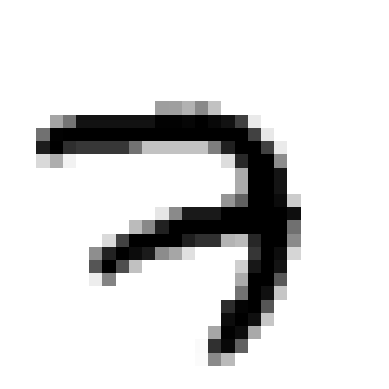

In [112]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [113]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [114]:
X_valid.shape

(5000, 28, 28)

In [115]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

<Figure size 1200x480 with 0 Axes>

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '7')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '3')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '4')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '6')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '1')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '8')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '1')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '0')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '9')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '8')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '0')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '3')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '1')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '2')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '7')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '0')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '2')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '9')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '6')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '0')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '1')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '6')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '7')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '1')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '9')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '7')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '6')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '5')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '5')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '8')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '8')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '3')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '4')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '4')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '8')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '7')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '3')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '6')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '4')

<AxesSubplot:>

(-0.5, 27.5, 27.5, -0.5)

Text(0.5, 1.0, '6')

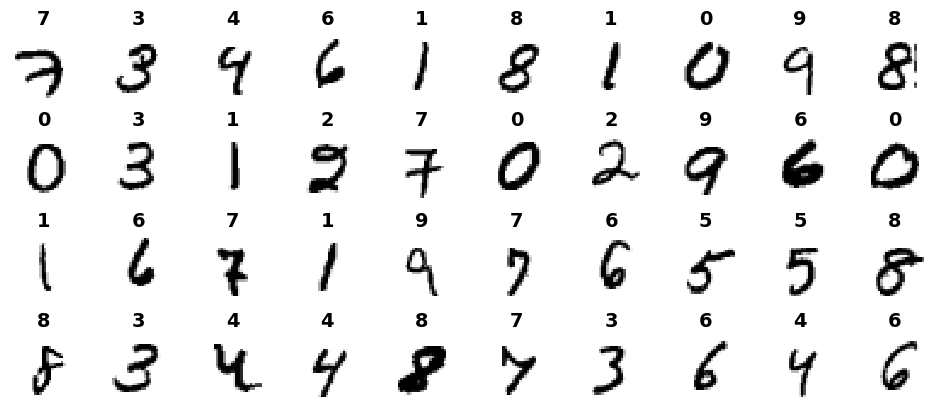

In [116]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [117]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [118]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [120]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [121]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 11s 6ms/step - loss: nan - accuracy: 0.6012 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

(0.0010000000474974513, 5.2636895179748535, 0.0, 2.3135464191436768)

Text(0.5, 0, 'Learning rate')

Text(0, 0.5, 'Loss')

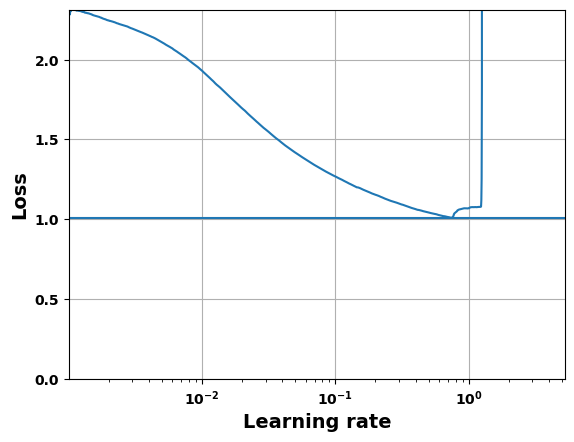

In [122]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [123]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [125]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [126]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

WindowsPath('my_mnist_logs/run_001')

In [127]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2366 - accuracy: 0.9260 - val_loss: 0.1039 - val_accuracy: 0.9696
Epoch 2/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0939 - accuracy: 0.9708 - val_loss: 0.0942 - val_accuracy: 0.9714
Epoch 3/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0657 - accuracy: 0.9791 - val_loss: 0.0804 - val_accuracy: 0.9760
Epoch 4/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0450 - accuracy: 0.9855 - val_loss: 0.0794 - val_accuracy: 0.9790
Epoch 5/100
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0360 - accuracy: 0.9883 - val_loss: 0.0802 - val_accuracy: 0.9796
Epoch 6/100
1719/1719 [==============================] - 9s 6ms/step - loss: 0.0299 - accuracy: 0.9903 - val_loss: 0.0919 - val_accuracy: 0.9782
Epoch 7/100
1719/1719 [==============================] - 9s 6ms/step - loss: 0.0214 - accuracy: 0.9935 - val_loss: 0.0805 - v

In [128]:
model = tf.keras.models.load_model("my_mnist_model") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0778 - accuracy: 0.9809


[0.07784350216388702, 0.98089998960495]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [129]:
# tensorboard --logdir "C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main\my_logs"